In [1]:
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
import pandas as pd
import numpy as np
from pandasql import sqldf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import mysql.connector as mysql_drive
from dotenv import load_dotenv
import os
load_dotenv()

# Set Pandas options to display more columns
pd.options.display.max_columns=150
import warnings
warnings.filterwarnings("ignore")

#Weighted Mean Absolute Percentage Error
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()
def wbpe(y_true, y_pred):
    return (y_true - y_pred).sum() / np.abs(y_true).sum()
def wcpe(wape, wbpe, beta):
    a = 1 - np.clip(wape, a_min = 0, a_max = 1)
    b = 1 - min(1, np.abs(wbpe))
    return ((1 + beta**2) * a * b) / (beta**2 * a + b)

In [2]:
#days_ago_60 = str((datetime.now() - timedelta(60) - timedelta(35)).date()) # - timedelta(21) bisa diubah agar jadi '2023-05-31'
#days_ago_37 = str((datetime.now() - timedelta(44) - timedelta(35)).date())
#days_ago_30 = str((datetime.now() - timedelta(30) - timedelta(35)).date())
#days_ago_14 = str((datetime.now() - timedelta(14) - timedelta(35)).date())
#days_ago_1 = str((datetime.now() - timedelta(1)   - timedelta(35)).date())

In [3]:
try:
    mydb = mysql_drive.connect(host=os.getenv("HOST"), user=os.getenv("DATABASE_USER"),port=os.getenv("DATABASE_PORT"),
                                database=os.getenv("DATABASE_NAME"), password=os.getenv("DATABASE_PASSWORD"))
    mycursor = mydb.cursor()
    mycursor.execute('''select max(date_format(sk_created_date,'%Y-%m-%d')) as last_date
    from digital_leads.digital_leads''')
    last_date = mycursor.fetchone()
except Exception as e:
    mydb.close()
    print(str(e))
print("Last Database date  : " , last_date)

Last Database date  :  ('2023-05-19',)


In [4]:
days_ago_1_str  = ''.join(last_date)
days_ago_1 = datetime.strptime(days_ago_1_str, '%Y-%m-%d').date()
days_ago_14 = days_ago_1 - timedelta(days = 13)
days_ago_30 = days_ago_1 - timedelta(days = 29)
days_ago_37 = days_ago_1 - timedelta(days = 36)
days_ago_60 = days_ago_1 - timedelta(days = 59)

print("days_ago_14 : " , days_ago_14)
print("days_ago_30 : " , days_ago_30)
print("days_ago_37 : " , days_ago_37)
print("days_ago_60 : " , days_ago_60)

days_ago_14 :  2023-05-06
days_ago_30 :  2023-04-20
days_ago_37 :  2023-04-13
days_ago_60 :  2023-03-21


In [5]:
try:
    mydb = mysql_drive.connect(host=os.getenv("HOST"), user=os.getenv("DATABASE_USER"),port=os.getenv("DATABASE_PORT"),
                                database=os.getenv("DATABASE_NAME"), password=os.getenv("DATABASE_PASSWORD"))
    query = '''
with meta As (
Select date_format(created_date,'%Y-%m-%d') as created_date,
	CASE WHEN lower(campaign_name) LIKE '%mobil%' THEN 'BPKB Mobil'
		 WHEN lower(campaign_name) LIKE '%motor%' THEN 'BPKB Motor'
		 WHEN lower(campaign_name) LIKE '%rumah%' THEN 'Sertifikat Rumah'
		 WHEN lower(campaign_name) LIKE '%all product%' THEN 'All Product'
		 WHEN lower(campaign_name) LIKE '%all-product%' THEN 'All Product'
		 else 'Others'
		 END AS product, ad_name, adset_name,
		campaign_name as campaign, 
		sum(clicks) as clicks, sum(spend) as cost
	from digital_leads.facebook_insights
	where campaign_name <> '(not set)'
			and date_format(created_date,'%Y-%m-%d') <= '{0}'
	group by created_date, campaign_name, product, ad_name, adset_name
),
leads As (
select utm_original, product,
		replace(replace(utm_content,"_"," "),"-"," ") as utm_content, 
        replace(replace(utm_term,"_"," "),"-"," ") as utm_term,
		date_format(sk_created_date,'%Y-%m-%d') as leads_date, sum(funnel_leads) as leads
    from digital_leads.digital_leads
    where submissionid is not null and group_utm_source = 'Meta'
          and product in ('BPKB Mobil', 'BPKB Motor', 'Sertifikat Rumah')
          and sk_created_date > 1 and utm_original is not null
    group by utm_original, utm_content, utm_term, product, sk_created_date
),
prospect As (
select utm_original, product, 
		replace(replace(utm_content,"_"," "),"-"," ") as utm_content, 
        replace(replace(utm_term,"_"," "),"-"," ") as utm_term,
        date_format(sk_closing_date,'%Y-%m-%d') as prospect_date, sum(funnel_prospect) as prospect
       from digital_leads.digital_leads
       where submissionid is not null and group_utm_source = 'Meta'
             and product in ('BPKB Mobil', 'BPKB Motor', 'Sertifikat Rumah')
             and sk_closing_date > 1 and utm_original is not null
       group by utm_original, utm_content, utm_term, product, sk_closing_date                
),
funding As (
select utm_original, product, 
		replace(replace(utm_content,"_"," "),"-"," ") as utm_content, 
        replace(replace(utm_term,"_"," "),"-"," ") as utm_term,
		date_format(sk_golive_date,'%Y-%m-%d') as funding_date, sum(funnel_funding) as funding,
		sum(case when funnel_funding = 1 then fundingamount  else 0 end) as NTF
       from digital_leads.digital_leads
       where submissionid is not null and group_utm_source = 'Meta'
             and product in ('BPKB Mobil', 'BPKB Motor', 'Sertifikat Rumah')
             and sk_golive_date > 1 and utm_original is not null
       group by utm_original, utm_content, utm_term, product, sk_golive_date
),
g_l As (
select g.created_date, g.product, g.ad_name, g.adset_name, g.campaign, g.clicks, g.cost, l.leads
	from meta as g
	left outer join leads as l on g.created_date = l.leads_date
						and g.campaign = l.utm_original
						and g.product = l.product
						and g.ad_name = l.utm_content
						and g.adset_name = l.utm_term
	where g.product not in ('All Product', 'Others')
union 
select l.leads_date as created_date, l.product, l.utm_content as ad_name, l.utm_term as adset_name,
		l.utm_original as campaign, g.clicks, g.cost, l.leads
	from meta as g
	right outer join leads as l on g.created_date = l.leads_date
						and g.campaign = l.utm_original
						and g.product = l.product
						and g.ad_name = l.utm_content
						and g.adset_name = l.utm_term
	where g.product not in ('All Product', 'Others')
)
,
g_lp As (
select gl.created_date, gl.product, gl.ad_name, gl.adset_name, gl.campaign, gl.clicks, gl.cost, gl.leads, p.prospect
	from g_l as gl
	left outer join prospect as p on gl.created_date = p.prospect_date
						and gl.campaign = p.utm_original
						and gl.product = p.product
						and gl.ad_name = p.utm_content
						and gl.adset_name = p.utm_term
union 
select p.prospect_date as created_date, p.product, p.utm_content as ad_name, p.utm_term as adset_name,
		p.utm_original as campaign, gl.clicks, gl.cost, gl.leads, p.prospect
	from g_l as gl
	right outer join prospect as p on gl.created_date = p.prospect_date
						and gl.campaign = p.utm_original
						and gl.product = p.product
						and gl.ad_name = p.utm_content
						and gl.adset_name = p.utm_term
)
select glp.created_date, glp.product, glp.ad_name, glp.adset_name, glp.campaign as campaign_name, glp.clicks, glp.cost, glp.leads, glp.prospect, f.funding, f.NTF
	from g_lp as glp
	left outer join funding as f on glp.created_date = f.funding_date
						and glp.campaign = f.utm_original
						and glp.product = f.product
						and glp.ad_name = f.utm_content
						and glp.adset_name = f.utm_term
union 
select f.funding_date as created_date, f.product, f.utm_content as ad_name, f.utm_term as adset_name,
		f.utm_original as campaign_name, glp.clicks, glp.cost, glp.leads, glp.prospect,
		f.funding, f.NTF
	from g_lp as glp
	right outer join funding as f on glp.created_date = f.funding_date
						and glp.campaign = f.utm_original
						and glp.product = f.product
						and glp.ad_name = f.utm_content
						and glp.adset_name = f.utm_term;    
    '''.format(days_ago_1)
    meta = pd.read_sql(query,mydb)
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))
meta['campaign']= meta['product'] +" # " + meta['ad_name'] +" # "+ meta["adset_name"] +" # "+ meta["campaign_name"]
#meta.head()

In [6]:
try:
    mydb = mysql_drive.connect(host=os.getenv("HOST"), user=os.getenv("DATABASE_USER"),port=os.getenv("DATABASE_PORT"),
                                database=os.getenv("DATABASE_NAME"), password=os.getenv("DATABASE_PASSWORD"))
    query = '''
        select campaign_name as campaign_name,
            CASE WHEN lower(campaign_name) LIKE '%mobil%' THEN 'BPKB Mobil'
		        WHEN lower(campaign_name) LIKE '%motor%' THEN 'BPKB Motor'
		        WHEN lower(campaign_name) LIKE '%rumah%' THEN 'Sertifikat Rumah'
		        WHEN lower(campaign_name) LIKE '%all product%' THEN 'All Product'
		        WHEN lower(campaign_name) LIKE '%all-product%' THEN 'All Product'
		        else 'Others'
		        END AS product, ad_name, adset_name,
            count(case when (created_date <= '{1}')then 1 end) as count_train,
            count(case when (created_date >= '{1}')then 1 end) as count_valid,
            min(date_format(created_date,'%Y-%m-%d')) as min, max(date_format(created_date,'%Y-%m-%d')) as max
        from digital_leads.facebook_insights
        where date_format(created_date,'%Y-%m-%d') <= '{3}' and campaign_name <> '(not set)'
        group by campaign_name, product, ad_name, adset_name
        having  min(date_format(created_date,'%Y-%m-%d')) <= '{0}' 
                and max(date_format(created_date,'%Y-%m-%d')) > '{2}'
                and count(case when (created_date <= '{1}')then 1 end) > 2
                and count(case when (created_date >= '{1}')then 1 end) > 2
    '''.format(days_ago_37,days_ago_30, days_ago_14,days_ago_1)
    active = pd.read_sql(query,mydb)
    mydb.close() #close the connection
except Exception as e:
    mydb.close()
    print(str(e))
active['campaign']= active['product'] +" # " + active['ad_name'] +" # "+ active["adset_name"] +" # "+ active["campaign_name"]
active

,campaign_name,product,ad_name,adset_name,count_train,count_valid,min,max,campaign
0,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Langsung Cair (Lancar) Video,Single Image & Video,95,26,2023-01-09,2023-05-19,BPKB Motor # Paket Langsung Cair (Lancar) Vide...
1,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Langsung Cair (Lancar) Video,Single Image & Video - Lookalike,74,26,2023-01-30,2023-05-19,BPKB Motor # Paket Langsung Cair (Lancar) Vide...
2,New Conversion | Jaminan BPKB Mobil | Web 1,BPKB Mobil,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,53,14,2023-02-08,2023-05-19,BPKB Mobil # Lebih Untung Dijaminkan Daripada ...
3,New Conversion | Jaminan BPKB Mobil | Web 1 | ...,BPKB Mobil,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,53,17,2023-02-08,2023-05-17,BPKB Mobil # Lebih Untung Dijaminkan Daripada ...
4,New Conversion | Jaminan BPKB Mobil | Web 1 | ...,BPKB Mobil,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,35,9,2023-02-08,2023-05-19,BPKB Mobil # Lebih Untung Dijaminkan Daripada ...
5,New Conversion | Jaminan BPKB Mobil | Web 1,BPKB Mobil,Pilihan Tepat Dapatkan Pinjaman Cepat,Mix Photo Video,54,14,2023-02-08,2023-05-19,BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman C...
6,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Lancar (Langsung Cair),Single Image & Video,65,26,2023-02-08,2023-05-19,BPKB Motor # Paket Lancar (Langsung Cair) # Si...
7,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Lancar (Langsung Cair),Single Image & Video - Lookalike,65,26,2023-02-08,2023-05-19,BPKB Motor # Paket Lancar (Langsung Cair) # Si...
8,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Reguler,Single Image & Video - Lookalike,65,26,2023-02-08,2023-05-19,BPKB Motor # Paket Reguler # Single Image & Vi...
9,New Conversion | Jaminan BPKB Motor | Web 1 | ...,BPKB Motor,Paket Reguler,Single Image & Video,65,26,2023-02-08,2023-05-19,BPKB Motor # Paket Reguler # Single Image & Vi...


In [7]:
Active_campaign = meta.loc[meta.campaign.isin(active.campaign.values)]
               #, ['googleAdsCampaignName', 'created_date', 'advertiserAdClicks', 'cost']]
Active_campaign['created_date'] = pd.to_datetime(Active_campaign['created_date']).dt.date
#Active_campaign.campaign.unique()
#Active_campaign.head()
#Active_campaign.info()

In [8]:
train_click = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'clicks']]
valid_click = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'clicks']]
train_cost = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'cost']]
valid_cost = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'cost']]
train_leads = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'leads']]
valid_leads = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'leads']]
train_prospect = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'prospect']]
valid_prospect = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'prospect']]
train_funding = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'funding']]
valid_funding = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'funding']]
train_NTF = Active_campaign.loc[Active_campaign['created_date'] < days_ago_30, ['campaign', 'created_date', 'NTF']]
valid_NTF = Active_campaign.loc[(Active_campaign['created_date'] >= days_ago_30) & (Active_campaign['created_date'] < days_ago_1), ['campaign', 'created_date', 'NTF']]

train_click = train_click.rename(columns={'created_date': 'ds', 'clicks': 'y', 'campaign': 'campaign'})
valid_click = valid_click.rename(columns={'created_date': 'ds', 'clicks': 'y', 'campaign': 'campaign'})
train_cost = train_cost.rename(columns={'created_date': 'ds', 'cost': 'y', 'campaign': 'campaign'})
valid_cost = valid_cost.rename(columns={'created_date': 'ds', 'cost': 'y', 'campaign': 'campaign'})
train_leads = train_leads.rename(columns={'created_date': 'ds', 'leads': 'y', 'campaign': 'campaign'})
valid_leads = valid_click.rename(columns={'created_date': 'ds', 'leads': 'y', 'campaign': 'campaign'})
train_prospect = train_prospect.rename(columns={'created_date': 'ds', 'prospect': 'y', 'campaign': 'campaign'})
valid_prospect = valid_prospect.rename(columns={'created_date': 'ds', 'prospect': 'y', 'campaign': 'campaign'})
train_funding = train_funding.rename(columns={'created_date': 'ds', 'funding': 'y', 'campaign': 'campaign'})
valid_funding = valid_funding.rename(columns={'created_date': 'ds', 'funding': 'y', 'campaign': 'campaign'})
train_NTF = train_NTF.rename(columns={'created_date': 'ds', 'NTF': 'y', 'campaign': 'campaign'})
valid_NTF = valid_NTF.rename(columns={'created_date': 'ds', 'NTF': 'y', 'campaign': 'campaign'})

train_click['ds']= pd.to_datetime(train_click['ds'])
valid_click['ds']= pd.to_datetime(valid_click['ds'])
train_cost['ds']= pd.to_datetime(train_cost['ds'])
valid_cost['ds']= pd.to_datetime(valid_cost['ds'])
train_leads['ds']= pd.to_datetime(train_leads['ds'])
valid_leads['ds']= pd.to_datetime(valid_leads['ds'])
train_prospect['ds']= pd.to_datetime(train_prospect['ds'])
valid_prospect['ds']= pd.to_datetime(valid_prospect['ds'])
train_funding['ds']= pd.to_datetime(train_funding['ds'])
valid_funding['ds']= pd.to_datetime(valid_funding['ds'])
train_NTF['ds']= pd.to_datetime(train_NTF['ds'])
valid_NTF['ds']= pd.to_datetime(valid_NTF['ds'])

In [9]:
click = list()
for campaign in train_click['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_click.loc[train_click['campaign'] == campaign]
    valid_ = valid_click.loc[valid_click['campaign'] == campaign]

    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    if train_.shape[0] > 2:
        m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    click.append(forecast[['ds', 'yhat', 'campaign']])
    
click = pd.concat(click, ignore_index=True)
click['yhat'] = click['yhat'].clip(lower=0)
click = click.merge(valid_click, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(click['y'], click['yhat']))
print("WBPE : " , wbpe(click['y'], click['yhat']))
print("WCPE : " , wcpe(wape(click['y'], click['yhat']), wbpe(click['y'], click['yhat']),2))

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek


10:57:27 - cmdstanpy - INFO - Chain [1] start processing
10:57:27 - cmdstanpy - INFO - Chain [1] done processing
10:57:28 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera


10:57:28 - cmdstanpy - INFO - Chain [1] done processing
10:57:28 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:28 - cmdstanpy - INFO - Chain [1] done processing
10:57:28 - cmdstanpy - INFO - Chain [1] start processing
10:57:28 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:28 - cmdstanpy - INFO - Chain [1] start processing
10:57:28 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera


10:57:28 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing
10:57:29 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:29 - cmdstanpy - INFO - Chain [1] done processing
10:57:29 - cmdstanpy - INFO - Chain [1] start processing
10:57:29 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:29 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:29 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing
10:57:30 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:30 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Mobil # Dana Pendidikan Anak Aman dengan Pinjaman Jaminan BPKB Mobil # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek


10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:30 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:30 - cmdstanpy - INFO - Chain [1] done processing
10:57:31 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:31 - cmdstanpy - INFO - Chain [1] done processing
10:57:31 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:31 - cmdstanpy - INFO - Chain [1] done processing
10:57:31 - cmdstanpy - INFO - Chain [1] start processing
10:57:31 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase
campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:31 - cmdstanpy - INFO - Chain [1] start processing
10:57:32 - cmdstanpy - INFO - Chain [1] done processing
10:57:32 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:32 - cmdstanpy - INFO - Chain [1] done processing
10:57:32 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:32 - cmdstanpy - INFO - Chain [1] done processing
10:57:32 - cmdstanpy - INFO - Chain [1] start processing
10:57:32 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:32 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:33 - cmdstanpy - INFO - Chain [1] done processing
10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase


10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:33 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:33 - cmdstanpy - INFO - Chain [1] start processing
10:57:34 - cmdstanpy - INFO - Chain [1] done processing
10:57:34 - cmdstanpy - INFO - Chain [1] start processing
10:57:34 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Remarketing # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:34 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:37 - cmdstanpy - INFO - Chain [1] done processing
10:57:37 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:38 - cmdstanpy - INFO - Chain [1] done processing
10:57:38 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Remarketing # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:38 - cmdstanpy - INFO - Chain [1] done processing
10:57:38 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:38 - cmdstanpy - INFO - Chain [1] done processing
10:57:39 - cmdstanpy - INFO - Chain [1] start processing
10:57:39 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase


10:57:39 - cmdstanpy - INFO - Chain [1] start processing
10:57:39 - cmdstanpy - INFO - Chain [1] done processing
10:57:39 - cmdstanpy - INFO - Chain [1] start processing
10:57:39 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:39 - cmdstanpy - INFO - Chain [1] start processing
10:57:39 - cmdstanpy - INFO - Chain [1] done processing
10:57:39 - cmdstanpy - INFO - Chain [1] start processing
10:57:39 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:40 - cmdstanpy - INFO - Chain [1] start processing
10:57:40 - cmdstanpy - INFO - Chain [1] done processing
10:57:40 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:40 - cmdstanpy - INFO - Chain [1] done processing
10:57:40 - cmdstanpy - INFO - Chain [1] start processing
10:57:40 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:40 - cmdstanpy - INFO - Chain [1] start processing
10:57:40 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
WAPE :  2.284225398420298
WBPE :  -1.4810818338520269
WCPE :  nan


In [10]:
cost = list()
for campaign in train_cost['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_cost.loc[train_cost['campaign'] == campaign]
    valid_ = valid_cost.loc[valid_cost['campaign'] == campaign]
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    cost.append(forecast[['ds', 'yhat', 'campaign']])
    
cost = pd.concat(cost, ignore_index=True)
cost['yhat'] = cost['yhat'].clip(lower=0)
cost = cost.merge(valid_cost, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(cost['y'], cost['yhat']))
print("WBPE : " , wbpe(cost['y'], cost['yhat']))
print("WCPE : " , wcpe(wape(cost['y'], cost['yhat']), wbpe(cost['y'], cost['yhat']),2))

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek


10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:41 - cmdstanpy - INFO - Chain [1] done processing
10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:41 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:41 - cmdstanpy - INFO - Chain [1] done processing
10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:41 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:41 - cmdstanpy - INFO - Chain [1] start processing
10:57:42 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek


10:57:42 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera


10:57:42 - cmdstanpy - INFO - Chain [1] done processing
10:57:42 - cmdstanpy - INFO - Chain [1] start processing
10:57:42 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:42 - cmdstanpy - INFO - Chain [1] start processing
10:57:42 - cmdstanpy - INFO - Chain [1] done processing
10:57:42 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:42 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Dana Pendidikan Anak Aman dengan Pinjaman Jaminan BPKB Mobil # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek


10:57:43 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:43 - cmdstanpy - INFO - Chain [1] done processing
10:57:43 - cmdstanpy - INFO - Chain [1] start processing
10:57:43 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:44 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:44 - cmdstanpy - INFO - Chain [1] done processing
10:57:44 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:44 - cmdstanpy - INFO - Chain [1] done processing
10:57:44 - cmdstanpy - INFO - Chain [1] start processing
10:57:44 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:44 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase


10:57:44 - cmdstanpy - INFO - Chain [1] done processing
10:57:45 - cmdstanpy - INFO - Chain [1] start processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:45 - cmdstanpy - INFO - Chain [1] done processing
10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:45 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek
campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek


10:57:45 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase


10:57:46 - cmdstanpy - INFO - Chain [1] start processing
10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:46 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Remarketing # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:46 - cmdstanpy - INFO - Chain [1] done processing
10:57:47 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:49 - cmdstanpy - INFO - Chain [1] done processing
10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Remarketing # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 - Jabodetabek


10:57:49 - cmdstanpy - INFO - Chain [1] start processing
10:57:49 - cmdstanpy - INFO - Chain [1] done processing
10:57:49 - cmdstanpy - INFO - Chain [1] start processing


campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase


10:57:50 - cmdstanpy - INFO - Chain [1] done processing
10:57:50 - cmdstanpy - INFO - Chain [1] start processing
10:57:50 - cmdstanpy - INFO - Chain [1] done processing


campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance Video # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:50 - cmdstanpy - INFO - Chain [1] start processing
10:57:50 - cmdstanpy - INFO - Chain [1] done processing
10:57:50 - cmdstanpy - INFO - Chain [1] start processing
10:57:50 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Lancar (Langsung Cair) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing
10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Reguler # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing
10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng


10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing
10:57:51 - cmdstanpy - INFO - Chain [1] start processing
10:57:51 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Motor # Paket Reguler (Video) # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabarteng
WAPE :  1.001146812241404
WBPE :  -0.14680260696445976
WCPE :  0.0


In [11]:
leads = list()
for campaign in train_leads['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_leads.loc[train_leads['campaign'] == campaign]
    valid_ = valid_leads.loc[valid_leads['campaign'] == campaign]
    train_['y'] = train_.iloc[-2:, train_.columns.get_loc('y')].fillna(0)
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    leads.append(forecast[['ds', 'yhat', 'campaign']])
    
leads = pd.concat(leads, ignore_index=True)
leads['yhat'] = leads['yhat'].clip(lower=0)
leads = leads.merge(valid_leads, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(leads['y'], leads['yhat']))
print("WBPE : " , wbpe(leads['y'], leads['yhat']))
print("WCPE : " , wcpe(wape(leads['y'], leads['yhat']), wbpe(leads['y'], leads['yhat']),2))

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:52 - cmdstanpy - INFO - Chain [1] start processing
10:57:52 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase
campaign: BPKB Mobil # Dana Pendidikan Anak Aman dengan 

In [12]:
prospect = list()
for campaign in train_prospect['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_prospect.loc[train_prospect['campaign'] == campaign]
    valid_ = valid_prospect.loc[valid_prospect['campaign'] == campaign]
    train_['y'] = train_.iloc[-2:, train_.columns.get_loc('y')].fillna(0)
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    prospect.append(forecast[['ds', 'yhat', 'campaign']])
    
prospect = pd.concat(prospect, ignore_index=True)
prospect['yhat'] = prospect['yhat'].clip(lower=0)
prospect = prospect.merge(valid_prospect, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(prospect['y'], prospect['yhat']))
print("WBPE : " , wbpe(prospect['y'], prospect['yhat']))
print("WCPE : " , wcpe(wape(prospect['y'], prospect['yhat']), wbpe(prospect['y'], prospect['yhat']),2))

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1


10:57:56 - cmdstanpy - INFO - Chain [1] start processing
10:57:56 - cmdstanpy - INFO - Chain [1] done processing


campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase | Jabodetabek
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase
campaign: BPKB Motor # Paket Langsung Cair (Lancar) Video # Single Image & Video - Lookalike # New Conversion | Jaminan BPKB Motor | Web 1 | Event Purchase
campaign: BPKB Mobil # Dana Pendidikan Anak Aman dengan 

In [13]:
funding = list()
for campaign in train_funding['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_funding.loc[train_funding['campaign'] == campaign]
    valid_ = valid_funding.loc[valid_funding['campaign'] == campaign]
    train_['y'] = train_.iloc[-2:, train_.columns.get_loc('y')].fillna(0)

    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    funding.append(forecast[['ds', 'yhat', 'campaign']])
    
funding = pd.concat(funding, ignore_index=True)
funding['yhat'] = funding['yhat'].clip(lower=0)
funding = funding.merge(valid_funding, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(funding['y'], funding['yhat']))
print("WBPE : " , wbpe(funding['y'], funding['yhat']))
print("WCPE : " , wcpe(wape(funding['y'], funding['yhat']), wbpe(funding['y'], funding['yhat']),2))

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BP

In [14]:
NTF = list()
for campaign in train_NTF['campaign'].unique():
    print('campaign:', campaign)
    train_ = train_NTF.loc[train_NTF['campaign'] == campaign]
    valid_ = valid_NTF.loc[valid_NTF['campaign'] == campaign]
    train_['y'] = train_.iloc[-2:, train_.columns.get_loc('y')].fillna(0)
    
    m = Prophet(seasonality_mode='additive', yearly_seasonality=False, 
                weekly_seasonality=True, daily_seasonality=True
               )
    m.fit(train_)
    
    future = m.make_future_dataframe(periods=60, include_history=False)
    future = future.merge(valid_[['ds']], on='ds', how='left')
    forecast = m.predict(future)
    forecast['campaign'] = campaign
    NTF.append(forecast[['ds', 'yhat', 'campaign']])
    
NTF = pd.concat(NTF, ignore_index=True)
NTF['yhat'] = NTF['yhat'].clip(lower=0)
NTF = NTF.merge(valid_NTF, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(NTF['y'], NTF['yhat']))
print("WBPE : " , wbpe(NTF['y'], NTF['yhat']))
print("WCPE : " , wcpe(wape(NTF['y'], NTF['yhat']), wbpe(NTF['y'], NTF['yhat']),2))


campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Sumatera
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Motor # Paket Reguler # Single Image # New Conversion | Jaminan BP

In [15]:
hist_click = train_click.loc[train_click['ds'].dt.date >= days_ago_60]
result_click = pd.concat([hist_click, click], ignore_index=True)
hist_cost = train_cost.loc[train_cost['ds'].dt.date >= days_ago_60]
result_cost = pd.concat([hist_cost, cost], ignore_index=True)
hist_leads = train_leads.loc[train_leads['ds'].dt.date >= days_ago_60]
result_leads = pd.concat([hist_leads, leads], ignore_index=True)
hist_prospect = train_prospect.loc[train_prospect['ds'].dt.date >= days_ago_60]
result_prospect = pd.concat([hist_prospect, prospect], ignore_index=True)
hist_funding = train_funding.loc[train_funding['ds'].dt.date >= days_ago_60]
result_funding = pd.concat([hist_funding, funding], ignore_index=True)
hist_NTF = train_NTF.loc[train_NTF['ds'].dt.date >= days_ago_60]
result_NTF = pd.concat([hist_NTF, NTF], ignore_index=True)

In [16]:
Click_SMA = []
ma_window=14

y_hat_sma = result_click[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_click,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_click.loc[hist_click['campaign'] == campaign])
    valid_ = valid_click.loc[valid_click['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Click_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Click_SMA_df = pd.concat(Click_SMA, ignore_index=True)
Click_SMA_df = Click_SMA_df.merge(valid_click, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']), wbpe(Click_SMA_df['y'], Click_SMA_df['lag1_sma_forecast']),2))

result_click = result_click.merge(Click_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')


campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [17]:
Cost_SMA = []
ma_window=14

y_hat_sma = result_cost[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_cost,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_cost.loc[hist_cost['campaign'] == campaign])
    valid_ = valid_cost.loc[valid_cost['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Cost_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Cost_SMA_df = pd.concat(Cost_SMA, ignore_index=True)
Cost_SMA_df = Cost_SMA_df.merge(valid_cost, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']), wbpe(Cost_SMA_df['y'], Cost_SMA_df['lag1_sma_forecast']),2))

result_cost = result_cost.merge(Cost_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [18]:
Leads_SMA = []
ma_window=14

y_hat_sma = result_leads[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_leads,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_leads.loc[hist_leads['campaign'] == campaign])
    valid_ = valid_leads.loc[valid_leads['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Leads_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Leads_SMA_df = pd.concat(Leads_SMA, ignore_index=True)
Leads_SMA_df = Leads_SMA_df.merge(valid_leads, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']), wbpe(Leads_SMA_df['y'], Leads_SMA_df['lag1_sma_forecast']),2))

result_leads = result_leads.merge(Leads_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [19]:
Prospect_SMA = []
ma_window=14

y_hat_sma = result_prospect[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_prospect,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_prospect.loc[hist_prospect['campaign'] == campaign])
    valid_ = valid_prospect.loc[valid_prospect['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Prospect_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Prospect_SMA_df = pd.concat(Prospect_SMA, ignore_index=True)
Prospect_SMA_df = Prospect_SMA_df.merge(valid_prospect, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']), wbpe(Prospect_SMA_df['y'], Prospect_SMA_df['lag1_sma_forecast']),2))

result_prospect = result_prospect.merge(Prospect_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [20]:
Funding_SMA = []
ma_window=14

y_hat_sma = result_funding[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_funding,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_funding.loc[hist_funding['campaign'] == campaign])
    valid_ = valid_funding.loc[valid_funding['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    Funding_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
Funding_SMA_df = pd.concat(Funding_SMA, ignore_index=True)
Funding_SMA_df = Funding_SMA_df.merge(valid_funding, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']), wbpe(Funding_SMA_df['y'], Funding_SMA_df['lag1_sma_forecast']),2))

result_funding = result_funding.merge(Funding_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [21]:
NTF_SMA = []
ma_window=14

y_hat_sma = result_NTF[['ds','campaign']]
y_hat_sma = pd.merge(y_hat_sma,
                 train_NTF,
                 left_on=['ds','campaign'], right_on = ['ds','campaign'], 
                 how='left')

for campaign in y_hat_sma['campaign'].unique():
    print('campaign:', campaign)
    train_ = y_hat_sma.loc[y_hat_sma['campaign'] == campaign].reset_index(drop=True)
    
    train_len = len(hist_NTF.loc[hist_NTF['campaign'] == campaign])
    valid_ = valid_NTF.loc[valid_NTF['campaign'] == campaign]
    #print(train_len)
    
    for x in range(59): #
        train_['sma_forecast'] = train_['y'].rolling(ma_window).mean()
        train_["lag1_sma_forecast"] = (train_.groupby(["campaign"])["sma_forecast"].shift())
        train_.y[train_len:train_len+x+1] = train_.lag1_sma_forecast[train_len:train_len+x+1]
    #print(train_.tail(55))
    
    NTF_SMA.append(train_[['ds', 'lag1_sma_forecast', 'campaign']])
    
NTF_SMA_df = pd.concat(NTF_SMA, ignore_index=True)
NTF_SMA_df = NTF_SMA_df.merge(valid_NTF, on=['ds', 'campaign'], how='left')
print("WAPE : " , wape(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']))
print("WBPE : " , wbpe(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']))
print("WCPE : " , wcpe(wape(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']), wbpe(NTF_SMA_df['y'], NTF_SMA_df['lag1_sma_forecast']),2))

result_NTF = result_NTF.merge(NTF_SMA_df[['ds','campaign','lag1_sma_forecast']], on=['ds', 'campaign'], how='left')

campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: BPKB Mobil # Lebih Untung Dijaminkan Daripada Dijual # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Pilihan Tepat Dapatkan Pinjaman Cepat # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1 | Jabodetabek
campaign: BPKB Mobil # Dana Pendidikan Anak Aman # Mix Photo Video # New Conversion | Jaminan BPKB Mobil | Web 1
campaign: Sertifikat Rumah # Pinjaman Besar Jaminan Sertifikat Rumah # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: Sertifikat Rumah # Pinjaman Jaminan Sertifikat Rumah di BFI Finance # Mix Photo & Video # BFI Finance | Conversion | Jaminan Sertifikat Rumah | Web 1 | Event Purchase
campaign: 

In [22]:
result_click['metrics'] = 'Click'
result_cost['metrics'] = 'Cost'
result_leads['metrics'] = 'Leads'
result_prospect['metrics'] = 'Prospect'
result_funding['metrics'] = 'Funding'
result_NTF['metrics'] = 'NTF'
forecast_list = [result_click, result_cost, result_leads, result_prospect, result_funding, result_NTF]
forecast_meta = pd.concat(forecast_list)
forecast_meta['source'] = 'Meta'
forecast_meta = forecast_meta.merge(active[['campaign','product','ad_name','adset_name','campaign_name']], on=['campaign'], how='left')
del forecast_meta["campaign"]
forecast_meta.rename(columns = {'ds':'date', 'y':'actual','yhat':'forecast','lag1_sma_forecast':'baseline', 'campaign_name' : 'campaign'}, inplace = True)
forecast_meta = forecast_meta.reindex(['source','product','metrics','campaign','ad_name','adset_name','date','actual','forecast','baseline'], axis=1)
forecast_meta.head()

,source,product,metrics,campaign,ad_name,adset_name,date,actual,forecast,baseline
0,Meta,BPKB Mobil,Click,New Conversion | Jaminan BPKB Mobil | Web 1,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,2023-03-23,550.0,NaN,NaN
1,Meta,BPKB Mobil,Click,New Conversion | Jaminan BPKB Mobil | Web 1,Pilihan Tepat Dapatkan Pinjaman Cepat,Mix Photo Video,2023-03-21,486.0,NaN,NaN
2,Meta,BPKB Mobil,Click,New Conversion | Jaminan BPKB Mobil | Web 1 | ...,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,2023-03-25,15.0,NaN,NaN
3,Meta,BPKB Mobil,Click,New Conversion | Jaminan BPKB Mobil | Web 1,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,2023-04-03,358.0,NaN,NaN
4,Meta,BPKB Mobil,Click,New Conversion | Jaminan BPKB Mobil | Web 1,Lebih Untung Dijaminkan Daripada Dijual,Mix Photo Video,2023-03-22,578.0,NaN,NaN


In [23]:
forecast_meta.to_csv('forecast_meta.csv', index=False)

IndexError: index 6 is out of bounds for axis 0 with size 6

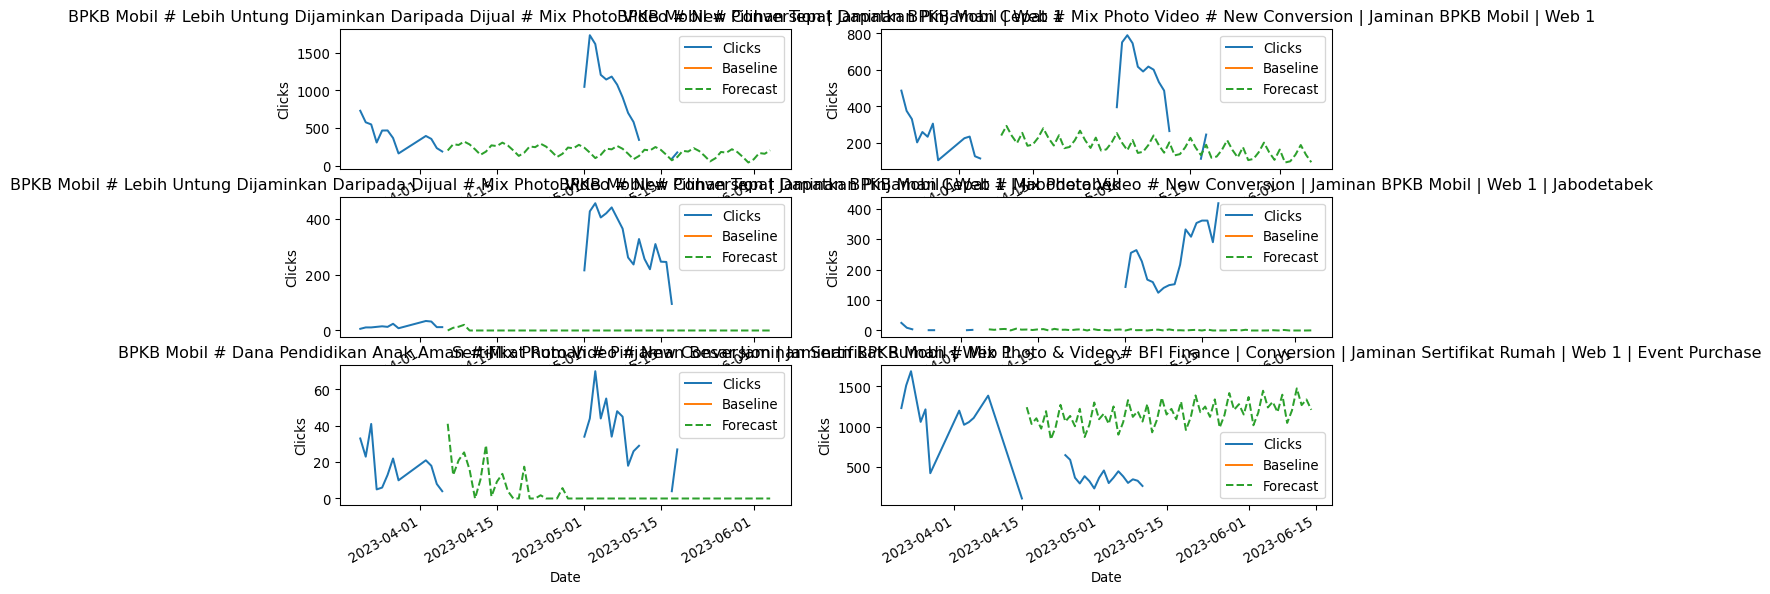

In [24]:
fig, ax = plt.subplots(3,2, figsize=(1280/96, 700/96), dpi=96)
ax = ax.flatten()
for ax_ ,campaign in enumerate(result_click['campaign'].unique()[:11]):
    p_ = result_click.loc[result_click['campaign'] == campaign]
    p_.plot(x='ds', y='y', ax=ax[ax_], label='Clicks')
    p_.plot(x='ds', y='lag1_sma_forecast', ax=ax[ax_], label='Baseline')
    p_.plot(x='ds', y='yhat', ax=ax[ax_], label='Forecast', linestyle='dashed')
    ax[ax_].set_title(campaign)
    ax[ax_].legend()
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Clicks')
fig.tight_layout()
plt.show()